<a href="https://www.kaggle.com/code/neupane9sujal/obesity-risk-prediction-majority-voting-with-oof?scriptVersionId=164837300" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier,early_stopping,log_evaluation
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn import set_config
import warnings
import optuna
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
data = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
original_data = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')
data = pd.concat([data, original_data]).drop(['id'], axis=1).drop_duplicates()

In [4]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
test_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22845 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          22845 non-null  object 
 1   Age                             22845 non-null  float64
 2   Height                          22845 non-null  float64
 3   Weight                          22845 non-null  float64
 4   family_history_with_overweight  22845 non-null  object 
 5   FAVC                            22845 non-null  object 
 6   FCVC                            22845 non-null  float64
 7   NCP                             22845 non-null  float64
 8   CAEC                            22845 non-null  object 
 9   SMOKE                           22845 non-null  object 
 10  CH2O                            22845 non-null  float64
 11  SCC                             22845 non-null  object 
 12  FAF                             22845 

<Axes: xlabel='Gender', ylabel='count'>

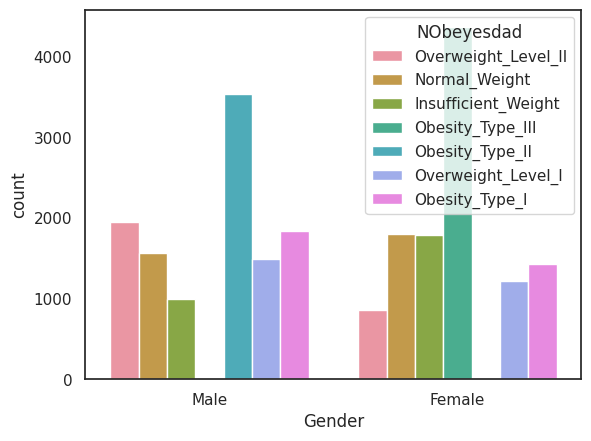

In [6]:
sns.countplot(data=data,x='Gender',hue='NObeyesdad')

<Axes: xlabel='family_history_with_overweight', ylabel='count'>

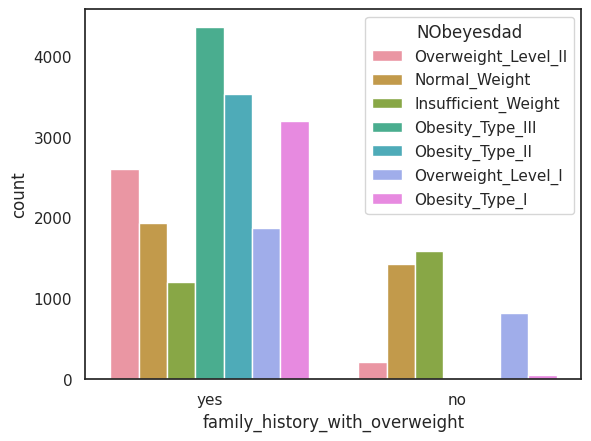

In [7]:
sns.countplot(data=data,x='family_history_with_overweight',hue='NObeyesdad')

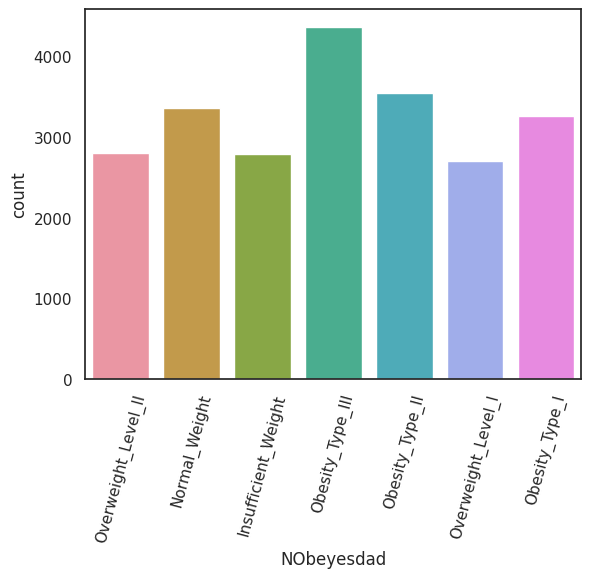

In [8]:
sns.countplot(data=data,x='NObeyesdad')
plt.xticks(rotation=75)
plt.show()

In [9]:
class Preprocessor:
    def __init__(self,df,test,original):
        self.data = df
        self.test = test 
        self.original_data = original
        
    def encode(self,data):
            transformed_data = data.copy()
            transformed_data['Gender'] = transformed_data['Gender'].map({"Male":1,"Female":0}).astype(np.uint8)
            transformed_data['family_history_with_overweight'] = transformed_data.family_history_with_overweight.map({"yes":1,"no":0}).astype(np.uint8)
            transformed_data['FAVC'] = transformed_data.FAVC.map({"yes":1,"no":0}).astype(np.uint8)
            transformed_data['CAEC'] = transformed_data.CAEC.map({"Sometimes":0, "Frequently":1, "no":2, "Always":3}).astype(np.uint8)
            transformed_data.SMOKE = transformed_data.SMOKE.map({"yes":1,"no":0}).astype(np.uint8)
            transformed_data.SCC = transformed_data.SCC.map({"yes":1,"no":0}).astype(np.uint8)
            transformed_data.CALC = transformed_data.CALC.map({"Sometimes":0, "Frequently":1, "no":2})
            transformed_data.MTRANS = transformed_data.MTRANS.map({"Public_Transportation":0,
                                                                   "Automobile":1,
                                                                   "Walking":2,
                                                                   "Motorbike":3,
                                                                   "Bike":4}).astype(np.uint8)
            
            return transformed_data
        
        
    def transform_data(self,mode):
        if mode == 'train':
            transformed_data = self.encode(self.data)
            
        else:
            transformed_data = self.encode(self.test)
            
        return transformed_data
        
    

In [10]:
preprocessor = Preprocessor(data,test_df,original_data)
train = preprocessor.transform_data('train')
test = preprocessor.transform_data('test')
#original_data = preprocessor.transform_data('original')

In [19]:
class Model:
    def __init__(self,train,test):
        self.train = train
        self.test = test
        self.num_cols = [col for col in self.train.columns if self.train[col].dtype in ['float64', 'int64'] and col != 'id']
        self.cat_cols = [col for col in self.train.columns if col not in self.num_cols and col!='NObeyesdad']
        
        
    def train_lgb(self):
        target_col = ['NObeyesdad']

        train_cols = self.num_cols + self.cat_cols
        test_predict_list = []
        all_test_predictions = []
        
        scores = list()
        for i in range(1):
            print(f"Iteration:{i+1}")
            rkf = RepeatedKFold(n_splits=30,n_repeats=1,random_state=42+i*i)
            
            for fold,(train_idx,valid_idx) in enumerate(rkf.split(self.train[train_cols],self.train[target_col])):
                X_train,y_train = self.train.iloc[train_idx][train_cols],np.array(self.train.iloc[train_idx][target_col]).ravel()
                X_valid,y_valid = self.train.iloc[valid_idx][train_cols],np.array(self.train.iloc[valid_idx][target_col]).ravel()
                
                model = LGBMClassifier(**{
                    "objective": "multiclass",          
                    "metric": "multi_logloss",          
                    "verbosity": -1,
                    'random_state':0,
                    'learning_rate': 0.05828871870812271,
                     'n_estimators': 159,
                     'lambda_l1': 0.15395856554089996,
                     'lambda_l2': 0.2913233407307633,
                     'feature_fraction': 0.4193073138371244,
                     'max_depth': 20,
                     'colsample_bytree': 0.918042564259133,
                     'subsample': 0.9602243741487563,
                     'min_child_samples': 47,
                     'device':'gpu'
                })
                early_stopping_callback = early_stopping(100,first_metric_only=True,verbose=False)
                verbose_callback  = log_evaluation(100)
                model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],
                     callbacks=[early_stopping_callback,verbose_callback],eval_metric='multi_logloss')
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
                
                valid_preds = model.predict(X_valid)
                test_preds = model.predict(self.test[train_cols])

                test_predict_list.append(test_preds)

                acc_score = accuracy_score(y_valid, model.predict(X_valid))
                scores.append(acc_score)
                print(f"\nFold: {fold+1}\n===>Accuracy score: {acc_score}")
            all_test_predictions.extend(test_predict_list)
            
        pprint(f"The average accuracy score is {np.mean(np.array(scores))}")
        # Convert the list of arrays to a 3D array
        predictions_3d = np.array(all_test_predictions)

        # Perform majority voting to find the final prediction for each entry
        final_predictions = []
        for entry_predictions in predictions_3d.T:  # Iterate over each entry's predictions
            unique, counts = np.unique(entry_predictions, return_counts=True)
            final_predictions.append(unique[np.argmax(counts)])

        return final_predictions
    def objective(self,trial):
        target_col = ['NObeyesdad']

        train_cols = self.num_cols + self.cat_cols
        test_predict_list = []
        acc_score_list = []
        all_test_predictions = []

        for i in range(1):
            #print(f"Iteration:{i+1}")
            rkf = RepeatedKFold(n_splits=5,n_repeats=1,random_state=42+i*i)

            for fold,(train_idx,valid_idx) in enumerate(rkf.split(self.train[train_cols],self.train[target_col])):
                X_train,y_train = self.train.iloc[train_idx][train_cols],np.array(self.train.iloc[train_idx][target_col]).ravel()
                X_valid,y_valid = self.train.iloc[valid_idx][train_cols],np.array(self.train.iloc[valid_idx][target_col]).ravel()

                model = LGBMClassifier(**{
                    "objective": "multiclass",
                    "metric": "multi_logloss",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                    "random_state": 0,
                    "num_class": 7,
                    'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
                    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                    'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0, 1.0),
                    'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0, 1.0),
                    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.25, 1.0),
                    'max_depth': trial.suggest_int('max_depth', 5, 20),
                    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
                    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
                    'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
                    'device': 'gpu'
                })
                early_stopping_callback = early_stopping(100,first_metric_only=True,verbose=False)
                verbose_callback  = log_evaluation(100)
                model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],
                     callbacks=[early_stopping_callback,verbose_callback],eval_metric='multi_logloss')
                model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

                valid_preds = model.predict(X_valid)
                test_preds = model.predict(self.test[train_cols])

                test_predict_list.append(test_preds)

                acc_score = accuracy_score(y_valid, model.predict(X_valid))
                acc_score_list.append(acc_score)
                
            return np.mean(np.array(acc_score_list))
        
    def find_params(self):
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective,350)

        # Get the best parameters
        best_params = study.best_params
        return best_params

In [20]:
model = Model(train,test)
predictions = model.train_lgb()
#model.find_params()

Iteration:1
[100]	valid_0's multi_logloss: 0.247314

Fold: 1
===>Accuracy score: 0.9225721784776902
[100]	valid_0's multi_logloss: 0.250202

Fold: 2
===>Accuracy score: 0.9186351706036745
[100]	valid_0's multi_logloss: 0.275408

Fold: 3
===>Accuracy score: 0.905511811023622
[100]	valid_0's multi_logloss: 0.25209

Fold: 4
===>Accuracy score: 0.9238845144356955
[100]	valid_0's multi_logloss: 0.250087

Fold: 5
===>Accuracy score: 0.9199475065616798
[100]	valid_0's multi_logloss: 0.267147

Fold: 6
===>Accuracy score: 0.9068241469816273
[100]	valid_0's multi_logloss: 0.278434

Fold: 7
===>Accuracy score: 0.9041994750656168
[100]	valid_0's multi_logloss: 0.24675

Fold: 8
===>Accuracy score: 0.9291338582677166
[100]	valid_0's multi_logloss: 0.251105

Fold: 9
===>Accuracy score: 0.9238845144356955
[100]	valid_0's multi_logloss: 0.269855

Fold: 10
===>Accuracy score: 0.8976377952755905
[100]	valid_0's multi_logloss: 0.273913

Fold: 11
===>Accuracy score: 0.9094488188976378
[100]	valid_0's multi

In [21]:
submit = pd.DataFrame({'id':test_df['id'],
                     'NObeyesdad':predictions})
submit.to_csv('submission.csv',index=False)
submit

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Overweight_Level_I
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight
